In [1]:
# import packages
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from itertools import combinations 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Risk Calculation System

### 1. Data preparation
   - 1.1 Import data & Construct dataframe
   - 1.2 User Interface & Construct portfolios

### 2. Three Methods for 99% VaR & 97.5% ES
   - 2.1 Parametric Method
       - Unweighted Parameters (window = 1,2,5)
       - Weighted Parameters (lambda = 0.994514,0.997253,0.998900)
   - 2.2 Historical Method
        - Relative change
        - Absolute change
   - 2.3 Monte Carlo Method
        - Unweighted Parameters (window = 1,2,5)
        - Weighted Parameters (lambda = 0.994514,0.997253,0.998900)
   - 2.4 Compare three VaR

### 3. Backtesting
   - 3.1 Historical Loss
   - 3.2 Backtesting for loss exceptions
   - 3.3 Robustness and Stability

## * MAIN CODE *

### 1. Data preparation

#### 1.1 Import data & Construct dataframe

In [2]:
AMZN = pd.read_csv('AMZN.csv')
MSFT = pd.read_csv('MSFT.csv')
APPL = pd.read_csv('APPL.csv')
XRX = pd.read_csv('XRX.csv')
KO = pd.read_csv('KO.csv')
SPX = pd.read_csv("SP500.csv")

In [3]:
SPX.head()

,Dates,PX_LAST,Call_Vol,Put_Vol,Risk_free_rate
0,12/10/2004,1188.00,14.98,14.01,2.25
1,12/13/2004,1198.68,15.03,14.18,2.24
2,12/14/2004,1203.38,15.07,14.23,2.21
3,12/15/2004,1205.72,14.81,14.32,2.21
4,12/16/2004,1203.21,14.93,14.09,2.20


In [4]:
Price_df = pd.concat([AMZN['PX_LAST'], MSFT['PX_LAST'],APPL['PX_LAST'],
                      XRX['PX_LAST'],KO['PX_LAST'],SPX['PX_LAST'],
                      AMZN['Risk_free_rate']],axis=1, ignore_index=True)
Price_df['Dates'] = pd.to_datetime(AMZN.Dates).dt.date
Price_df= Price_df.set_index('Dates')
Price_df.columns = ['AMZN','MSFT','APPL','XRX','KO','SPX','Risk_free_rate']

In [5]:
Put_vol_df = pd.concat([AMZN['Put_Vol'], MSFT['Put_Vol'],APPL['Put_Vol'],
                        XRX['Put_Vol'],KO['Put_Vol'],SPX['Put_Vol']],
                       axis=1, ignore_index=True)
Put_vol_df['Dates'] = pd.to_datetime(AMZN.Dates).dt.date
Put_vol_df= Put_vol_df.set_index('Dates')
Put_vol_df.columns = ['AMZN','MSFT','APPL','XRX','KO','SPX']

In [6]:
Call_vol_df = pd.concat([AMZN['Call_Vol'], MSFT['Call_Vol'],APPL['Call_Vol'],
                         XRX['Call_Vol'],KO['Call_Vol'],SPX['Call_Vol']],
                        axis=1, ignore_index=True)
Call_vol_df['Dates'] = pd.to_datetime(AMZN.Dates).dt.date
Call_vol_df= Call_vol_df.set_index('Dates')
Call_vol_df.columns = ['AMZN','MSFT','APPL','XRX','KO','SPX']

In [7]:
Price_df.head()

,AMZN,MSFT,APPL,XRX,KO,SPX,Risk_free_rate
Dates,,,,,,,
2004-12-10,39.05,27.08,4.654,42.2589,20.265,1188.00,2.25
2004-12-13,39.83,27.25,4.636,43.2337,20.430,1198.68,2.24
2004-12-14,40.44,27.23,4.664,42.9439,20.650,1203.38,2.21
2004-12-15,41.00,27.11,4.661,43.1810,20.735,1205.72,2.21
2004-12-16,40.05,27.16,4.757,43.6025,20.565,1203.21,2.20


In [8]:
Put_vol_df.head()

,AMZN,MSFT,APPL,XRX,KO,SPX
Dates,,,,,,
2004-12-10,39.368,19.570,40.695,30.357,18.067,14.01
2004-12-13,39.550,19.774,40.885,28.539,17.955,14.18
2004-12-14,39.736,19.609,40.709,28.994,17.845,14.23
2004-12-15,39.612,19.645,41.014,29.314,17.906,14.32
2004-12-16,39.539,19.716,41.533,28.564,17.861,14.09


In [9]:
Call_vol_df.head()

,AMZN,MSFT,APPL,XRX,KO,SPX
Dates,,,,,,
2004-12-10,39.398,20.127,40.796,31.000,19.242,14.98
2004-12-13,39.714,19.778,41.209,29.486,19.101,15.03
2004-12-14,39.370,20.296,41.171,29.294,18.885,15.07
2004-12-15,39.382,20.158,41.328,29.841,18.909,14.81
2004-12-16,39.822,19.864,42.078,28.848,19.323,14.93


#### 1.2 User Interface & Construct portfolios

In [10]:
Stocks = input("Enter the stocks you want to invest : ")

Enter the stocks you want to invest : MSFT, XRX, SPX


In [11]:
Option = input("Enter the option you choose : ")

Enter the option you choose : SPX


In [12]:
Money = input("Enter the money you want to invest in each stock and option : ")

Enter the money you want to invest in each stock and option : 2000, 3000, 2000, 1500, 1500


In [13]:
Position = input("Enter the position of the portfolio : ")

Enter the position of the portfolio : long


In [14]:
t = input("Enter the time interval of the VaR :") or 5/252

Enter the time interval of the VaR :


In [15]:
p1 = input("Enter the percentile of the VaR ; ") or 0.99

Enter the percentile of the VaR ; 


In [16]:
p2 = input("Enter the percentile of the ES ; ") or 0.975

Enter the percentile of the ES ; 


In [17]:
Money = [int(i) for i in Money.split(", ")] 
Stocks = Stocks.split(", ")


In [18]:
# Total value
V0 = sum(Money)

In [19]:
# Option value
def BSPut(S,K,t,r,v):
    d1 = (np.log(S/K)+(t)*(r+0.5*v**2))/(v*np.sqrt(t))
    d2 = d1-v*np.sqrt(t)
    put =K*np.exp(-r*(t))*norm.cdf(-d2)-S*norm.cdf(-d1)
    return put

def BSCall(S, K, t, r, v):
    d1 = (np.log(S/K) + (r + (v**2)/2)*t)/(v*np.sqrt(t))   
    d2 = d1 - v*np.sqrt(t)  
    call = S*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    return call

In [20]:
S = K = Price_df[Option]
callv = Call_vol_df[Option]/100
putv = Put_vol_df[Option]/100
r = Price_df['Risk_free_rate']/100

Callprice = BSCall(S,K,1,r,callv)
Putprice = BSPut(S,K,1,r,putv)

In [21]:
# Price Table
Tables = Price_df[Stocks]
Tables['Call'] = list(Callprice)
Tables['Put'] = list(Putprice)
Tables.head()

,MSFT,XRX,SPX,Call,Put
Dates,,,,,
2004-12-10,27.08,42.2589,1188.00,84.145305,53.234235
2004-12-13,27.25,43.2337,1198.68,85.072819,54.559033
2004-12-14,27.23,42.9439,1203.38,85.406949,55.171348
2004-12-15,27.11,43.1810,1205.72,84.353004,55.700607
2004-12-16,27.16,43.6025,1203.21,84.676999,54.563426


In [22]:
# Shares 
Shares = [] 
for i in range(0, len(Money)): 
    Shares.append(Money[i] / list(Tables.iloc[0,])[i]) 

In [23]:
# Portfolio
def Portfolio(stocks,shares):
    
    port = (stocks*shares).sum(axis=1)
    result = pd.concat([Tables,port],axis =1)
    #result  = result[len(result)-252*10:]
    
    return result


In [24]:
Portfolio = Portfolio(Tables,Shares)
Portfolio.rename(columns = {list(Portfolio)[5]:'Portfolio'}, inplace=True)

In [25]:
Portfolio.head()

,MSFT,XRX,SPX,Call,Put,Portfolio
Dates,,,,,,
2004-12-10,27.08,42.2589,1188.00,84.145305,53.234235,10000.000000
2004-12-13,27.25,43.2337,1198.68,85.072819,54.559033,10153.600640
2004-12-14,27.23,42.9439,1203.38,85.406949,55.171348,10162.672528
2004-12-15,27.11,43.1810,1205.72,84.353004,55.700607,10170.706431
2004-12-16,27.16,43.6025,1203.21,84.676999,54.563426,10173.829163


### 2. Three methods

#### 2.1 Parametric method

In [26]:
# Obtain parameters -- mu & sigma

def unweighted_parameter(stock,t,window):
    column_names = [str(window)+'Y mu', str(window)+'Y vol']
    window = 252*window
    ret = np.log(stock/stock.shift(1))
    vol = ret.rolling(window=window).std()/np.sqrt(t)
    mu = ret.rolling(window=window).mean()/t + (vol*vol)/2
    result = pd.concat([mu, vol], axis=1)
    result.columns = column_names
    #result  = result[len(result)-252*10:]
    
    return result

def weighted_parameter(stock,t,lambda_set):
    column_names = ['mu '+str(lambda_set), 'vol '+str(lambda_set)]
    ret = np.log(stock/stock.shift(1))
    vol = ret.ewm(alpha = 1 - lambda_set).std()/np.sqrt(t)
    mu = ret.ewm(alpha = 1 - lambda_set).mean()/t + (vol*vol)/2
    result = pd.concat([mu, vol], axis=1)
    result.columns = column_names
    #result  = result[len(result)-252*10:]

    return result

In [27]:
def Portfolio_Para_VaR(Port_value,V0,t,p,Unwe_or_We,Position,win_or_lam):
    #unweighted parameter
    if Unwe_or_We == "UnWe":
        params = unweighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
        if Position == 'long':
            VaR = V0 - V0*np.exp(vol*np.sqrt(t)*norm.ppf(1-p)+(mu-vol*vol/2)*t)
        if Position == 'short':
            VaR  = V0*np.exp(np.sqrt(t)*vol*norm.ppf(p)+(mu-vol*vol/2)*t)-V0
        VaR = VaR[len(VaR)-252*10:]
   
    #weighted parameter
    elif Unwe_or_We == "We":
        params = weighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
        VaR = V0 - V0*np.exp(vol*np.sqrt(t)*norm.ppf(1-p)+(mu-vol*vol/2)*t)
        VaR = VaR[len(VaR)-252*10:]
            
    else: 
        VaR = 'NA'
        print("VaR is NA!")
        
    return VaR

In [28]:
def Portfolio_Para_ES(Port_value,V0,t,p,Unwe_or_We,Position,win_or_lam):

    if Unwe_or_We == "UnWe":
        params = unweighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
        if Position == 'long':
            ES = V0- V0*np.exp(mu*t)*norm.cdf(norm.ppf(1-p)-vol*np.sqrt(t))/(1-p)
        if Position == 'short':
            ES = V0*np.exp(mu*t)*norm.cdf(norm.ppf(1-p)-vol*np.sqrt(t))/(1-p)-V0
        ES = ES[len(ES)-252*10:]
        
    elif Unwe_or_We =="We":
        params = weighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
        ES = V0- V0*np.exp(mu*t)*norm.cdf(norm.ppf(1-p)-vol*np.sqrt(t))/(1-p)
        ES = ES[len(ES)-252*10:]
        
    else:
        ES = 'NA'
        print("ES is NA!")
        
    return ES

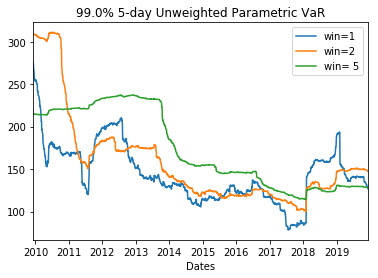

In [29]:
plt.figure()
Portfolio_Para_VaR(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',Position,1).plot()
Portfolio_Para_VaR(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',Position,2).plot()
Portfolio_Para_VaR(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',Position,5).plot()
plt.title(str(p1*100) + '% ' +str(int(t*252))+ '-day Unweighted Parametric VaR')
plt.legend(labels=['win=1','win=2','win= 5'])
plt.savefig('Unweighted Parametric VaR')

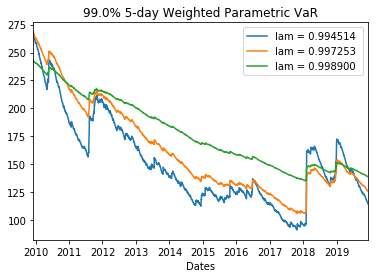

In [30]:
plt.figure()
Portfolio_Para_VaR(Portfolio.iloc[:,-1],V0,t,p1,'We',Position,0.994514).plot()
Portfolio_Para_VaR(Portfolio.iloc[:,-1],V0,t,p1,'We',Position,0.997253).plot()
Portfolio_Para_VaR(Portfolio.iloc[:,-1],V0,t,p1,'We',Position,0.998900).plot()
plt.title(str(p1*100) + '% ' +str(int(t*252))+ '-day Weighted Parametric VaR')
plt.legend(('lam = 0.994514 ','lam = 0.997253 ','lam = 0.998900'))
plt.savefig('Weighted Parametric VaR')

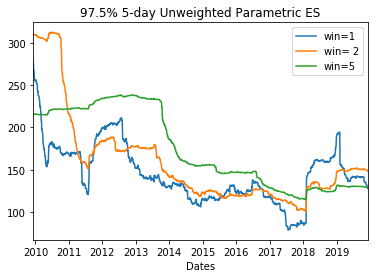

In [31]:
plt.figure()
Portfolio_Para_ES(Portfolio.iloc[:,-1],V0,t,p2,'UnWe',Position,1).plot()
Portfolio_Para_ES(Portfolio.iloc[:,-1],V0,t,p2,'UnWe',Position,2).plot()
Portfolio_Para_ES(Portfolio.iloc[:,-1],V0,t,p2,'UnWe',Position,5).plot()
plt.title(str(p2*100) + '% ' +str(int(t*252))+ '-day Unweighted Parametric ES')
plt.legend(labels=['win=1','win= 2','win=5'])
plt.savefig('Unweighted Parametric ES')

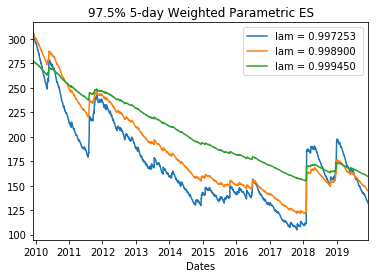

In [32]:
plt.figure()
Portfolio_Para_ES(Portfolio.iloc[:,-1],V0,t,p1,'We',Position,0.994514).plot()
Portfolio_Para_ES(Portfolio.iloc[:,-1],V0,t,p1,'We',Position,0.997253).plot()
Portfolio_Para_ES(Portfolio.iloc[:,-1],V0,t,p1,'We',Position,0.998900).plot()
plt.title(str(p2*100) + '% ' +str(int(t*252))+ '-day Weighted Parametric ES')
plt.legend(('lam = 0.997253 ','lam = 0.998900','lam = 0.999450'))
plt.savefig('Weighted Parametric ES')

#### 2.2 Historical method

In [33]:
def Portfolio_Hist_VaR(Port_value,V0,t,T,p,Abs_or_Rel):
    t = int(t*252)
 
    if Abs_or_Rel == "R":
        relative_return = Port_value/Port_value.shift(t)
        VaR = V0 - V0*(relative_return.rolling(T*252).quantile(1-p))
        VaR = VaR[len(VaR)-252*10:]   
        
    elif Abs_or_Rel == "A":
        abs_return = (Port_value-Port_value.shift(t))
        VaR = - V0* abs_return.rolling(T*252).quantile(1-p)/Port_value
        VaR = VaR[len(VaR)-252*10:]
        
    else: 
        VaR = 'NA'
        print("VaR is NA!")
    return VaR

In [34]:
def Portfolio_Hist_ES(Port_value,V0,t,T,p, Abs_or_Rel):
    t = int(t*252)
    
    if Abs_or_Rel == "R":
        relative_return = Port_value/Port_value.shift(t)
        ES = pd.Series(index=Port_value.index)
        ret_quantile = (relative_return.rolling(T*252).quantile(1-p))
        for i in range(len(relative_return)):
            ret_range = relative_return[i-T*252:i]
            ES[i] = V0 - V0 * ret_range[ret_range <= ret_quantile[i]].mean()   
        ES = ES[len(ES)-252*10:]
        
    elif Abs_or_Rel == "A":
        abs_return = (Port_value-Port_value.shift(t))
        ES = pd.Series(index=Port_value.index)
        abs_change_quantile = abs_return.rolling(T*252).quantile(1-p)
        for i in range(len(abs_return)):    
            ab_range = abs_return[i-T*252:i]
            ES[i] = - V0 * (ab_range[ab_range <= abs_change_quantile[i]].mean())/Port_value[i]
        ES = ES[len(ES)-252*10:]   
        
    else: 
        ES = 'NA'
        print("ES is NA!")
    return ES

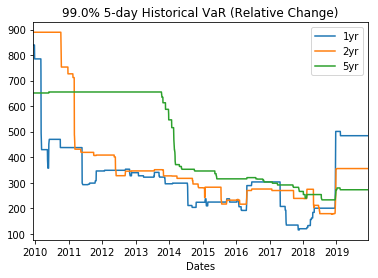

In [35]:
plt.figure()
Portfolio_Hist_VaR(Portfolio.iloc[:,-1],V0,t,1,p1,'R').plot()
Portfolio_Hist_VaR(Portfolio.iloc[:,-1],V0,t,2,p1,'R').plot()
Portfolio_Hist_VaR(Portfolio.iloc[:,-1],V0,t,5,p1,'R').plot()
plt.title(str(p1*100) + '% '+str(int(t*252))+'-day Historical VaR (Relative Change)')
plt.legend(labels = ['1yr','2yr','5yr'])
plt.savefig('Historical VaR (Relative Change)')

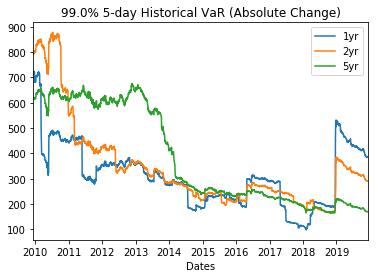

In [36]:
plt.figure()
Portfolio_Hist_VaR(Portfolio.iloc[:,-1],V0,t,1,p1,'A').plot()
Portfolio_Hist_VaR(Portfolio.iloc[:,-1],V0,t,2,p1,'A').plot()
Portfolio_Hist_VaR(Portfolio.iloc[:,-1],V0,t,5,p1,'A').plot()
plt.title(str(p1*100) + '% '+str(int(t*252))+'-day Historical VaR (Absolute Change)')
plt.legend(labels = ['1yr','2yr','5yr'])
plt.savefig('Historical VaR (Absolute Change)')

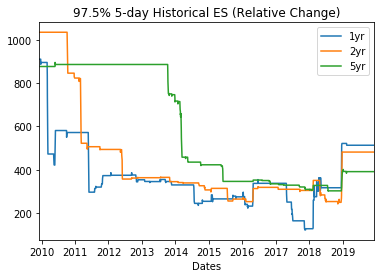

In [37]:
plt.figure()
Portfolio_Hist_ES(Portfolio.iloc[:,-1],V0,t,1,p1,'R').plot()
Portfolio_Hist_ES(Portfolio.iloc[:,-1],V0,t,2,p1,'R').plot()
Portfolio_Hist_ES(Portfolio.iloc[:,-1],V0,t,5,p1,'R').plot()
plt.title(str(p2*100) + '% '+str(int(t*252))+'-day Historical ES (Relative Change)')
plt.legend(labels = ['1yr','2yr','5yr'])
plt.savefig('Historical ES (Relative Change)')

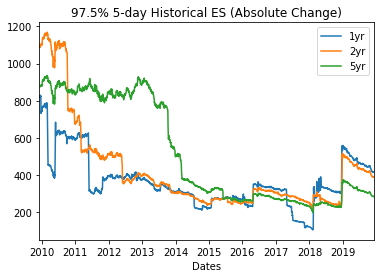

In [38]:
plt.figure()
Portfolio_Hist_ES(Portfolio.iloc[:,-1],V0,t,1,p1,'A').plot()
Portfolio_Hist_ES(Portfolio.iloc[:,-1],V0,t,2,p1,'A').plot()
Portfolio_Hist_ES(Portfolio.iloc[:,-1],V0,t,5,p1,'A').plot()
plt.title(str(p2*100) + '% '+str(int(t*252))+'-day Historical ES (Absolute Change)')
plt.legend(labels = ['1yr','2yr','5yr'])
plt.savefig('Historical ES (Absolute Change)')

#### 2.3 Monte Carlo method

In [39]:
def Portfolio_MC_VaR(Port_value,V0,t,p,Unwe_or_We,win_or_lam):
    
    if Unwe_or_We == "UnWe":
        params = unweighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
        w= pd.Series(index=mu.index)
        for i in range(len(params)):
            z = np.random.normal(0, np.sqrt(t), size=10000)
            w[i] = np.percentile(z, (1-p)*100)
        VaR = V0 - V0*np.exp((mu - 0.5*vol*vol)*t + vol*w)
        VaR = VaR[len(VaR)-252*10:]

    elif Unwe_or_We =="We":
        params = weighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
        w = pd.Series(index=mu.index)
        for i in range(len(params)):
            z = np.random.normal(0, np.sqrt(t), size=10000)
            w[i] = np.percentile(z, (1-p)*100)
        VaR = V0 - V0*np.exp((mu - 0.5*vol*vol)*t + vol*w)
        VaR = VaR[len(VaR)-252*10:]
    else: 
            VaR = 'NA'
            print("VaR is NA!")

    return VaR

In [40]:
def Portfolio_MC_ES(Port_value,V0,t,p,Unwe_or_We,win_or_lam):
    
    if Unwe_or_We == "UnWe":
        params = unweighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
        w = pd.Series(index=mu.index)
        for i in range(len(params)):
            z = np.random.normal(0, np.sqrt(t), size=10000)
            w[i] =z[z<np.percentile(z, (1-p)*100)].mean()
        ES = V0 - V0*np.exp((mu - 0.5*vol*vol)*t + vol*w)
        ES = ES[len(ES)-252*10:]

    elif Unwe_or_We =="We":
        params = weighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
        w = pd.Series(index=mu.index)
        for i in range(len(params)):
            z = np.random.normal(0, np.sqrt(t), size=10000)
            w[i] =z[z<np.percentile(z, (1-p)*100)].mean()
        ES =V0 - V0*np.exp((mu - 0.5*vol*vol)*t + vol*w)
        ES = ES[len(ES)-252*10:]
   
    else: 
            ES = 'NA'
            print("ES is NA!")
    return ES

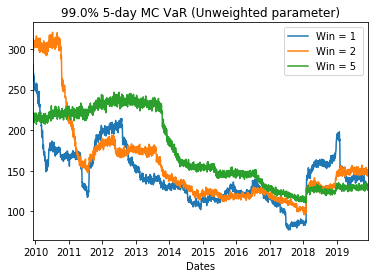

In [41]:
plt.figure()
Portfolio_MC_VaR(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',1).plot()
Portfolio_MC_VaR(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',2).plot()
Portfolio_MC_VaR(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',5).plot()
plt.title(str(p1*100) + '% ' +str(int(t*252))+ '-day MC VaR (Unweighted parameter)')
plt.legend(labels = ['Win = 1 ','Win = 2','Win = 5'])
plt.savefig('MC VaR (Unweighted parameter)')

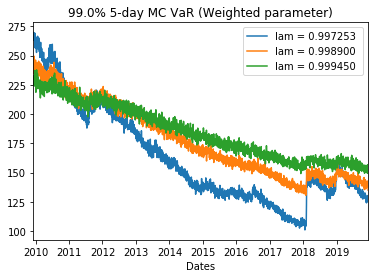

In [42]:
plt.figure()
Portfolio_MC_VaR(Portfolio.iloc[:,-1],V0,t,p1,'We',0.997253).plot()
Portfolio_MC_VaR(Portfolio.iloc[:,-1],V0,t,p1,'We',0.998900).plot()
Portfolio_MC_VaR(Portfolio.iloc[:,-1],V0,t,p1,'We',0.999450).plot()
plt.title(str(p1*100) + '% ' +str(int(t*252))+ '-day MC VaR (Weighted parameter)')
plt.legend(('lam = 0.997253 ','lam = 0.998900','lam = 0.999450'))
plt.savefig('MC VaR (Weighted parameter)')

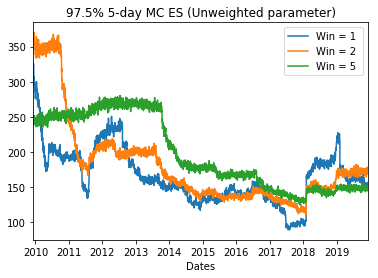

In [43]:
plt.figure()
Portfolio_MC_ES(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',1).plot()
Portfolio_MC_ES(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',2).plot()
Portfolio_MC_ES(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',5).plot()
plt.title(str(p2*100) + '% ' +str(int(t*252))+ '-day MC ES (Unweighted parameter)')
plt.legend(labels = ['Win = 1 ','Win = 2','Win = 5'])
plt.savefig('MC ES (Unweighted parameter)')

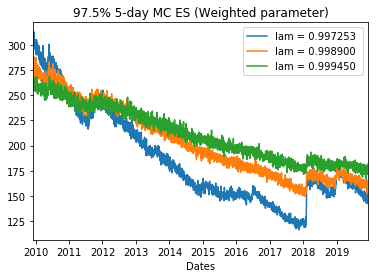

In [44]:
plt.figure()
Portfolio_MC_ES(Portfolio.iloc[:,-1],V0,t,p1,'We',0.997253).plot()
Portfolio_MC_ES(Portfolio.iloc[:,-1],V0,t,p1,'We',0.998900).plot()
Portfolio_MC_ES(Portfolio.iloc[:,-1],V0,t,p1,'We',0.999450).plot()
plt.title(str(p2*100) + '% ' +str(int(t*252))+ '-day MC ES (Weighted parameter)')
plt.legend(('lam = 0.997253 ','lam = 0.998900','lam = 0.999450'))
plt.savefig('MC ES (Weighted parameter)')

#### 2.4 Compare three VaRs

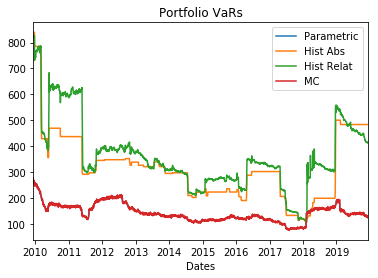

In [45]:
plt.figure()
Portfolio_Para_VaR(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',Position,1).plot()
Portfolio_Hist_VaR(Portfolio.iloc[:,-1],V0,t,1,p1,'R').plot()
Portfolio_Hist_ES(Portfolio.iloc[:,-1],V0,t,1,p1,'A').plot()
Portfolio_MC_VaR(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',1).plot()
plt.title('Portfolio VaRs')
plt.legend(('Parametric','Hist Abs','Hist Relat','MC')) 
plt.savefig('Three VaRs')

### 3. Backtesting

#### 3.1 Historical loss

In [46]:
def Hist_loss(V0,T,Port_value):
    loss = pd.DataFrame(index=Portfolio.index)
    loss2 =[0]*len(loss)
    for i in range(-T*252,-2):
        loss2[i] = V0*(1-Port_value.iloc[i-5]/Port_value.iloc[i])
    loss['loss']= loss2
    
    return loss

In [47]:
hist_loss1 = Hist_loss(V0,10,Portfolio.iloc[:,-1])

#### 3.2 Backtesting

In [48]:
def backtest(VaR,Hist_loss,T,d):
    backtest = pd.DataFrame(index=Portfolio.index)
    backtest['VaR'] = VaR
    backtest['Hist_loss'] = Hist_loss.iloc[:,0]
    
    loss_exceeds = [0]*len(backtest)
    exceptions = [0]*len(backtest)
    expected_exception = [2.5]*len(backtest)
    
    for i in range(-T*252,-2):
        if backtest['Hist_loss'][i] > backtest.iloc[i,0]:
            loss_exceeds[i] = 1
        else:
            loss_exceeds[i] = 0
    backtest['Loss exceeds VaR'] = loss_exceeds

    for i in range(-(T-1)*252,-2):            
        exceptions[i] = backtest['Loss exceeds VaR'][i:i+252].sum()

    backtest['Exceptions'] = exceptions
    backtest['Expected exceptions'] = expected_exception
    
    return backtest

In [49]:
var_para1 = Portfolio_Para_VaR(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',Position,2)
var_histr1 = Portfolio_Hist_VaR(Portfolio.iloc[:,-1],V0,t,2,p1,'R')
var_hista1 = Portfolio_Hist_VaR(Portfolio.iloc[:,-1],V0,t,2,p1,'A')
var_mc1 = Portfolio_MC_VaR(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',2)

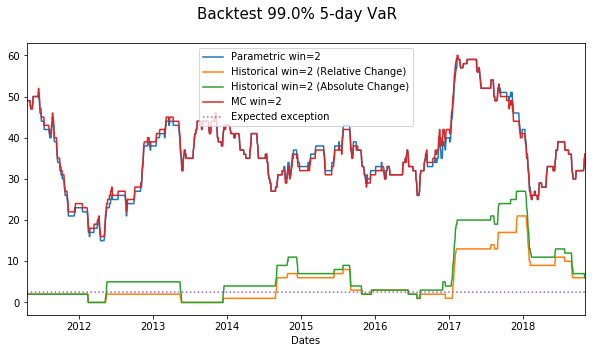

In [50]:
BT1 = plt.figure(figsize=(10,5))
BT1.suptitle('Backtest ' + str(p1*100) + '% ' + str(int(t*252)) + '-day VaR',
             fontsize=15)

backtest(var_para1,hist_loss1,10,5).iloc[1600:3500,3].plot()
backtest(var_histr1,hist_loss1,10,5).iloc[1600:3500,3].plot()
backtest(var_hista1,hist_loss1,10,5).iloc[1600:3500,3].plot()
backtest(var_mc1,hist_loss1,10,5).iloc[1600:3500,3].plot()
backtest(var_mc1,hist_loss1,10,5).iloc[1600:3500,4].plot(linestyle = ':')

plt.legend(('Parametric win=2','Historical win=2 (Relative Change)',
            'Historical win=2 (Absolute Change)','MC win=2','Expected exception'))
plt.savefig('Backtesting')

#### 3.3 Robustness and Stability

In [51]:
def Portfolio_Para_mu(Port_value,V0,t,p,Unwe_or_We,Position,win_or_lam):
    #unweighted parameter
    if Unwe_or_We == "UnWe":
        params = unweighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
      
   
    #weighted parameter
    elif Unwe_or_We == "We":
        params = weighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
      
    else: 
        mu = 'NA'
        print("VaR is NA!")
        
    return mu

def Portfolio_Para_vol(Port_value,V0,t,p,Unwe_or_We,Position,win_or_lam):
    #unweighted parameter
    if Unwe_or_We == "UnWe":
        params = unweighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
      
   
    #weighted parameter
    elif Unwe_or_We == "We":
        params = weighted_parameter(Port_value,t,win_or_lam)
        mu = params.iloc[:,0]
        vol = params.iloc[:,1]
      
    else: 
        mu = 'NA'
        print("VaR is NA!")
        
    return vol

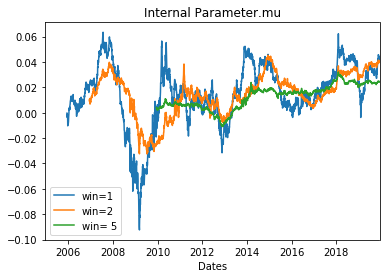

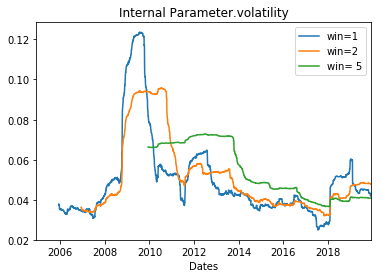

In [52]:
plt.figure()
Portfolio_Para_mu(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',Position,1).plot()
Portfolio_Para_mu(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',Position,2).plot()
Portfolio_Para_mu(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',Position,5).plot()
plt.title("Internal Parameter.mu")
plt.legend(labels=['win=1','win=2','win= 5'])
plt.savefig('mu')

plt.figure()
Portfolio_Para_vol(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',Position,1).plot()
Portfolio_Para_vol(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',Position,2).plot()
Portfolio_Para_vol(Portfolio.iloc[:,-1],V0,t,p1,'UnWe',Position,5).plot()
plt.title("Internal Parameter.volatility")
plt.legend(labels=['win=1','win=2','win= 5'])
plt.savefig('vol')